# Menu Recommender Using Turi Create (Popularity Recommender)

We saw in notebook [6. ALS_Recommender_System](#6._ALS_Recommender_System) under evaluation of the ALS Recommender System that it may be more useful to recommend popular items instead of making personalised recommendations. Using Turi Create, we build a recommender system to find the most popular items. To manage the highly varying magnitudes of purchase frequency, we normalize purchase frequency of each item across users. 

While just suggesting best-selling items may be a simple model (every user will have the same recommended products), it is especially useful for new users with whom we have no data of past transactions. This is called the “cold start” scenario.

## Date Import and Pre-processing

In [1]:
#Import libraries
import pandas as pd
import numpy as np
import time
import turicreate as tc
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split

In [2]:
#Import data
df = pd.read_csv('../inputs/profile_features_clean.csv')

In [3]:
# #Inspect data
# df.sample()

### Missing Values

In [4]:
#Check for missing values
df.isnull().sum()

account_balance                 0
card_brand_users             6670
has_coupon                      0
birthday_year               50475
birthday_month              50332
age                         50475
user_id                         0
address                         5
zone_id                         0
salesperson_id                  0
discount                        0
due_dates_only                  0
card_details                35326
card_brand_delivery_info    18550
source                          0
delivery_fee                    0
meal_wave                       0
surcharge_amount                0
promo_code_used                 0
gave_feedback                   0
district                        5
delivery_order_id               0
item_id                         5
item_type                       6
quantity                        0
unit_price                      5
name                          136
macros                        136
ingredients                   278
temperature   

I drop rows with name and item_id missing.

In [5]:
#Drop rows where item_id and name is missing
df = df[df.item_id.notnull() & df.name.notnull()]

In [6]:
#Inspect data types
df.dtypes

account_balance               int64
card_brand_users             object
has_coupon                    int64
birthday_year               float64
birthday_month              float64
age                         float64
user_id                       int64
address                      object
zone_id                     float64
salesperson_id                int64
discount                    float64
due_dates_only               object
card_details                 object
card_brand_delivery_info     object
source                       object
delivery_fee                float64
meal_wave                    object
surcharge_amount            float64
promo_code_used               int64
gave_feedback                 int64
district                    float64
delivery_order_id             int64
item_id                     float64
item_type                    object
quantity                    float64
unit_price                  float64
name                         object
macros                      

In [7]:
#Convert item_id to integer type
df.item_id = df.item_id.astype(int)

In [8]:
#Create data input with user_id, item_id and sum per quantity
data = df.groupby(['user_id','item_id']).quantity.sum().reset_index()
data.head()

,user_id,item_id,quantity
0,1,54,3.0
1,1,59,4.0
2,1,66,3.0
3,1,82,4.0
4,1,83,2.0


In [9]:
#Create user-item interaction matrix
df_matrix = pd.pivot_table(data, values='quantity', index='user_id', columns='item_id')
df_matrix.head()

item_id,5,25,30,49,54,59,66,82,83,84,...,627,629,630,631,633,646,647,648,649,650
user_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,3.0,4.0,3.0,4.0,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


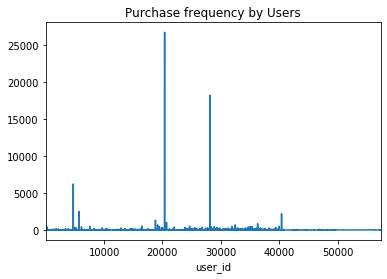

In [10]:
#Plot purchase frequency by Users
df.groupby('user_id').quantity.sum().plot()
plt.title('Purchase frequency by Users')
plt.show()

To manage the highly varying magnitudes of purchase frequency, we normalize purchase frequency of each item across users. The result is a value on a scale of 0 to 1, 0 being the min quantity purchased of an item, by any user.

In [11]:
#Normalise quantity purchased by each user on the scale of min-max quantity purchased of each item across all users
df_matrix_norm = (df_matrix-df_matrix.min())/(df_matrix.max()-df_matrix.min())
df_matrix_norm.head()

item_id,5,25,30,49,54,59,66,82,83,84,...,627,629,630,631,633,646,647,648,649,650
user_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,1.0,1.0,0.666667,0.085714,0.1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
#Redefine data input with scaled purchase frequency for modelling
data_norm = pd.melt(df_matrix_norm.reset_index(), id_vars=['user_id'], value_name='scaled_purchase_freq').dropna()

#Print number of data points 
print('There are {} records of transaction data with reference to {} menu items, purchased by {} unique users.'.format(data_norm.shape[0],data_norm.item_id.nunique(),data_norm.user_id.nunique()))

There are 39084 records of transaction data with reference to 296 menu items, purchased by 8859 unique users.


## Modelling

In [13]:
#Convert data input to SFrame recognised by Turi Create
data_norm = tc.SFrame(data_norm)

I build a model to recommend top 10 items.

In [14]:
#Define variables
user_id = 'user_id'
item_id = 'item_id'
users_to_recommend = list(df.user_id.unique())

#Set number of items to recommend
n_rec = 10

#Set number of rows to display
n_display = 10                                               

In [15]:
#Initialise and fit model
model = tc.popularity_recommender.create(tc.SFrame(data_norm), 
                                            user_id=user_id, 
                                            item_id=item_id, 
                                            target='scaled_purchase_freq')
#Get recommendations
recom = model.recommend(verbose=False,users=users_to_recommend, k=n_rec)

#Print recommendations
print('Top {} items recommended for {} of our users:'.format(n_rec,int(n_display/n_rec)))
recom.print_rows(n_display)

Preparing data set.

Data has 39084 observations with 8859 users and 296 items.

Data prepared in: 0.05155s

39084 observations to process; with 296 unique items.

Top 10 items recommended for 1 of our users:
+---------+---------+--------------------+------+
| user_id | item_id |       score        | rank |
+---------+---------+--------------------+------+
|  30268  |   156   |        0.75        |  1   |
|  30268  |   155   | 0.6153846153846154 |  2   |
|  30268  |   313   | 0.5555555555555556 |  3   |
|  30268  |   539   | 0.5277777777777778 |  4   |
|  30268  |   626   |        0.5         |  5   |
|  30268  |   527   |        0.5         |  6   |
|  30268  |   426   |        0.5         |  7   |
|  30268  |   396   |        0.5         |  8   |
|  30268  |   360   |        0.5         |  9   |
|  30268  |   346   |        0.5         |  10  |
+---------+---------+--------------------+------+
[88860 rows x 4 columns]



## Interpretation

Uncomment to see top items by popularity:

In [16]:
# #Retrieve item names
# item_name = df[['item_id','name']]

# #Define recommendations in dataframe
# def_rec = recom.to_dataframe()

# print('Popular items amongst users are:\n')
# #Iterate through item_id in recommendations to print name
# pop_lst = []
# for i in def_rec.item_id.unique():
#     pop_lst.append(df.loc[df.item_id ==i, 'name'].iloc[0])
# for k,v in enumerate(pop_lst,1):
#     print(str(k)+'. ',v)